<a href="https://colab.research.google.com/github/pbplop29/Photogrammetry/blob/main/Photogrammetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling the imports

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
from skimage import filters 
from google.colab.patches import cv2_imshow
import cv2
import matplotlib as mpl
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  

# Computing the Mapping/Scaling Factors 

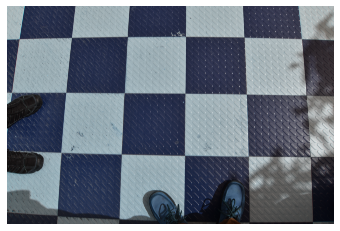

In [9]:
# Reading and plotting the calibration image 
image_name = 'map.JPG'
img = cv2.imread(image_name)
plt.axis('off')
plt.imshow(img)

In [5]:
# Handling the naming conventions, if we want to save the files
image_name_proper = image_name.rsplit( ".", 1 )[ 0 ]
image = skimage.io.imread(fname=image_name)
image_mask_name = image_name_proper + "---mask.JPG"
image_contours_name = image_name_proper + "---contours.JPG"
image_resized_name = image_name_proper + "--resized.JPG"
final_image_name = image_name_proper + "---final.JPG"

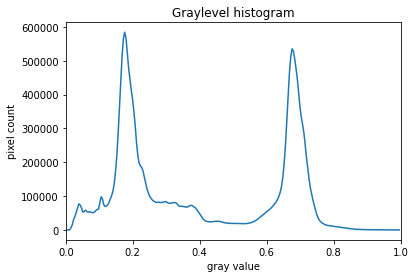

In [6]:
# Converting the Image to grayscale
gray_image = skimage.color.rgb2gray(img)
# Blur the image to denoise
blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)

# Finding the Optimal Threshold value

histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)
plt.show()

In [7]:
# Finding the optimum threshold value from above histogram
t = skimage.filters.threshold_otsu(blurred_image)
print("Found automatic threshold t = {}.".format(t))
t=t-0.15

Found automatic threshold t = 0.4376442014074442.


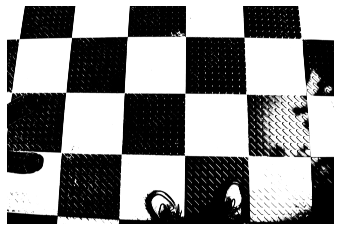

In [10]:
# Creating the threshold mask
binary_mask = blurred_image > t
fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap="gray")
plt.axis('off')
plt.savefig(image_mask_name,dpi=300*4.415,bbox_inches='tight',pad_inches = 0)
plt.show()

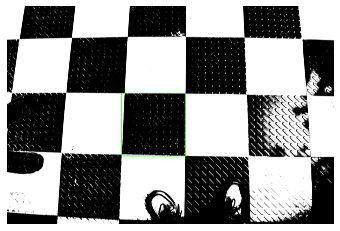

In [15]:
# Defining some simple functions for ease
def display(img):
    cv2_imshow(img)
def shape(img):
    print(img.shape)
def resize(img, width=100, height=100, inter=cv2.INTER_AREA):
    img = cv2.resize(img, (width,height), interpolation=inter)
    return img

# Finding the edges and plotting a contour around our calibration reference
img = cv2.imread(image_mask_name)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
edged = cv2.Canny(imgray, 30, 200,0)
dilate = cv2.dilate(thresh, None, iterations=1)
erode = cv2.erode(dilate, None, iterations=1)
contours, hierarchy = cv2.findContours(erode , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
count = 0
for c in contours:
    area = cv2.contourArea(c)
    if area >img.shape[0]*img.shape[1]*0.50 or area < img.shape[0]*img.shape[1]*0.005:
        pass
    else:
      if count == 0:
        count=count+1
        pass
      else:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 10)
        cv2.circle(img, (x + w//2, y + h//2), 5, (0, 0, 255), 2)
        break
plt.axis('off')
plt.imshow(img)